In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
#nodes type encodings
nodes_type_int_encodings = {
    "nuclei":0,
    "golgi":1
}

reversed_nodes_type_int_encodings = {v: k for k, v in nodes_type_int_encodings.items()}

#edges type encodings
edges_type_int_encodings = {
    "nuclei-nuclei":0,
    "golgi-golgi":1,
    "golgi-nuclei":2,
    "nuclei-golgi":3
}

reversed_edges_type_int_encodings = {v: k for k, v in edges_type_int_encodings.items()}

# Explore Original Dataset

In [3]:
def load_df_from_csv(gt_vectors_csv: str, column_names=['YN', 'XN', 'YG', 'XG', 'ZN', 'ZG'],
                     nuclei_columns=['YN', 'XN', 'ZN'],
                     golgi_columns=['YG', 'XG', 'ZG'],
                     nodes_type_int_encodings=nodes_type_int_encodings,
                    edges_type_int_encodings = edges_type_int_encodings):
    if("automatic" not in gt_vectors_csv):
        df = pd.read_csv(gt_vectors_csv, delimiter=",", header=None)
        df.columns = column_names

        # Split the DataFrame into two
        nuclei_df = df[nuclei_columns].copy().reset_index(drop=True)
        nuclei_df["node_type"] = nodes_type_int_encodings['nuclei']
        nuclei_df.rename(columns={'YN': 'Y', 'XN': 'X', 'ZN': 'Z'}, inplace=True)  # Rename nuclei columns

        golgi_df = df[golgi_columns].copy().reset_index(drop=True)
        golgi_df["node_type"] = nodes_type_int_encodings['golgi']
        golgi_df.rename(columns={'YG': 'Y', 'XG': 'X', 'ZG': 'Z'}, inplace=True)  # Rename golgi columns

        # Set the 'ID'
        golgi_df["ID"] = range(len(nuclei_df), len(nuclei_df) + len(golgi_df))
        nuclei_df["ID"] = range(len(nuclei_df))

        # Concatenate the two DataFrames into 'nodes_df'
        nodes_df = pd.concat([nuclei_df, golgi_df]).reset_index(drop=True)
        nodes_df["X"] = nodes_df["X"].apply(lambda x: x - 1)
        nodes_df["Y"] = nodes_df["Y"].apply(lambda y: y - 1)
        nodes_df["Z"] = nodes_df["Z"].apply(lambda z: z - 1)

        # Create edges between nuclei and golgi based on nodes in the same line
        edges_df = pd.DataFrame({'source': nuclei_df['ID'], 'target': golgi_df['ID']})
    else:
        df = pd.read_csv(gt_vectors_csv, delimiter=",")
        df["node_type"] = df["node_type"].apply(lambda x : nodes_type_int_encodings[x])
        nodes_df = df.copy()
        edges_df = pd.DataFrame(columns=['source', 'target', "edge_type"])#empty
        
    return df, nodes_df, edges_df

def concat_csv_from_dir(directory):
    # Get a list of all files in the directory
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.endswith('.csv')]
    
    # Read each file into a dataframe and store in a list
    dfs = []
    for f in all_files:
        f_path = os.path.join(directory, f)
        raw_df, nodes_df, edges_df = load_df_from_csv(f_path)
        dfs.append(nodes_df)
    
    # Concatenate all dataframes in the list into a single dataframe
    concatenated_df = pd.concat(dfs, ignore_index=True)
    
    return concatenated_df

def plot_statistics(df, fig):
    # Plot histograms for each feature
    n_cols = len(df.columns)
    axes = []
    for i, column in enumerate(df.columns):
        ax = fig.add_subplot(1, n_cols, i+1)  # 1 row, n_cols columns, position i+1
        df[column].hist(bins=30, ax=ax)
        ax.set_title(column)
        axes.append(ax)
    return fig

def describe_df(directory, fig):
    df = concat_csv_from_dir(directory)
    print(df.describe())

    df = df[["X", "Y", "Z"]]
    
    fig =  plot_statistics(df, fig)

    return fig

In [13]:
vector_dirs = [r'../data/vectors',
                r'../data/vectors_automatic_csv',
                   r'../data/synthetic_algo_1000_points',
]

               Y           X           Z  node_type          ID
count  964.00000  964.000000  964.000000  964.00000  964.000000
mean   263.26971  315.478216   20.306017    0.50000   66.769710
std    162.48365  176.579831    8.425640    0.50026   45.609236
min      2.00000    4.000000    1.000000    0.00000    0.000000
25%    131.75000  181.000000   14.000000    0.00000   30.000000
50%    244.50000  312.000000   20.000000    0.50000   60.000000
75%    404.00000  450.000000   26.000000    1.00000   96.250000
max    618.00000  810.000000   42.000000    1.00000  181.000000


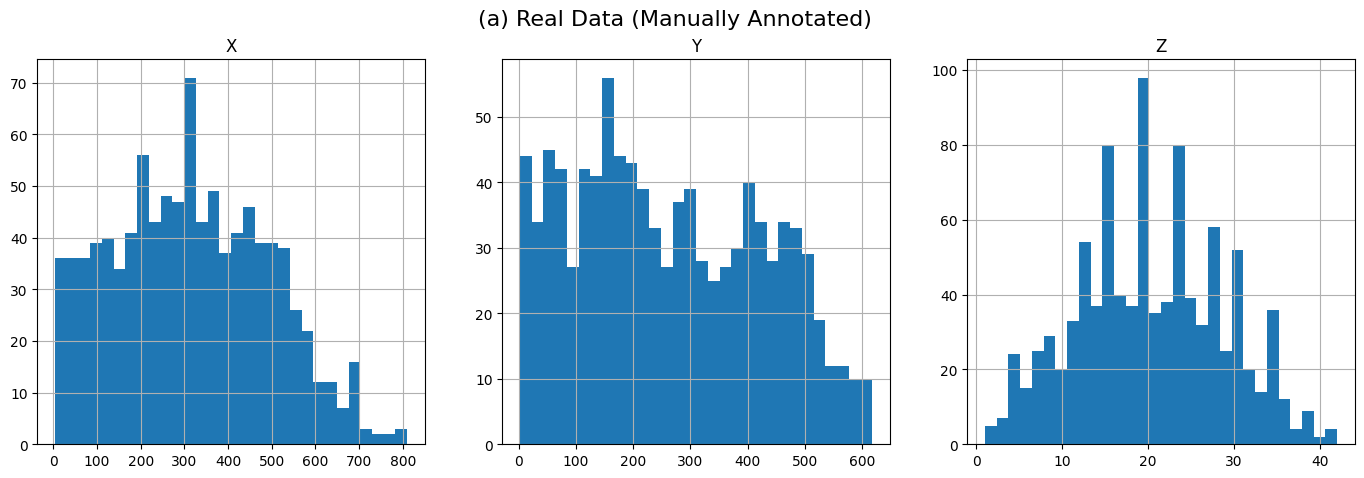

In [6]:
# Create a figure and subplots
fig = plt.figure(figsize=(17, 5))
fig.suptitle("(a) Real Data (Manually Annotated)", fontsize=16)
real_graphs_annotated_directory = vector_dirs[0]
real_graph_annotated_fig = describe_df(real_graphs_annotated_directory, fig)

                X           Y           Z   node_type          ID
count  913.000000  913.000000  913.000000  913.000000  913.000000
mean   328.935378  276.484118   19.489595    0.509310   62.744797
std    181.761511  159.395108    7.898073    0.500187   42.332093
min     25.000000   25.000000    5.000000    0.000000    0.000000
25%    190.000000  146.000000   13.000000    0.000000   28.000000
50%    322.000000  263.000000   19.000000    1.000000   57.000000
75%    460.000000  409.000000   25.000000    1.000000   90.000000
max    816.000000  624.000000   44.000000    1.000000  177.000000


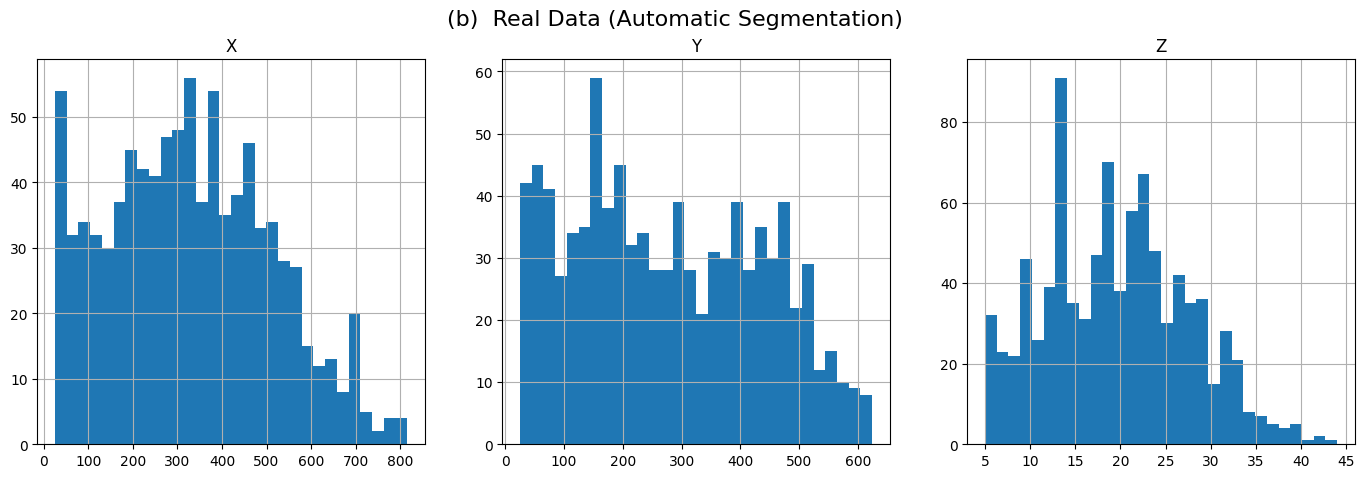

In [7]:
# Create a figure and subplots
fig = plt.figure(figsize=(17, 5))
fig.suptitle("(b)  Real Data (Automatic Segmentation)", fontsize=16)
real_graphs_automatic_directory = vector_dirs[1]
real_graphs_automatic_fig = describe_df(real_graphs_automatic_directory, fig)

                 Y            X            Z    node_type           ID
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000
mean     -1.730392     3.611120    -0.981645     0.500000   499.500000
std      11.767694    10.157443     0.930613     0.500031   288.693034
min     -37.013850   -20.012617    -4.878399     0.000000     0.000000
25%     -10.000000    -3.791651    -1.594746     0.000000   249.750000
50%       0.979362     2.294147    -0.980774     0.500000   499.500000
75%       7.000000     9.168444    -0.362626     1.000000   749.250000
max      21.000000    36.019759     3.008723     1.000000   999.000000


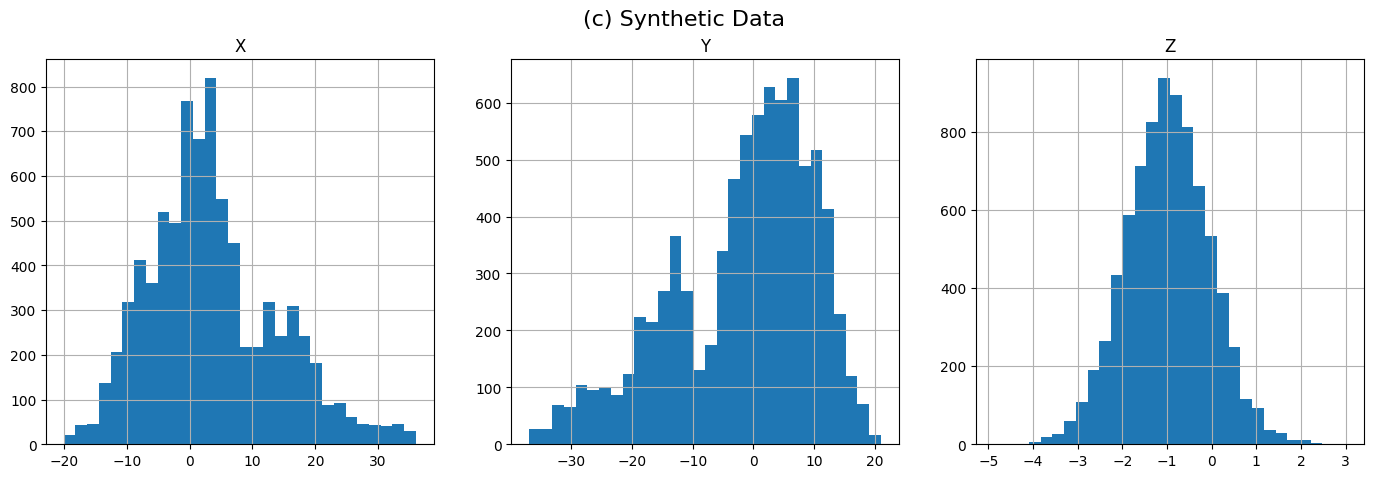

In [14]:
# Create a figure and subplots
fig = plt.figure(figsize=(17, 5))
fig.suptitle( "(c) Synthetic Data", fontsize=16)
synthetic_graphs_directory = vector_dirs[2]
synthetic_graphs_fig = describe_df(synthetic_graphs_directory, fig)

# Generate Artificial Data

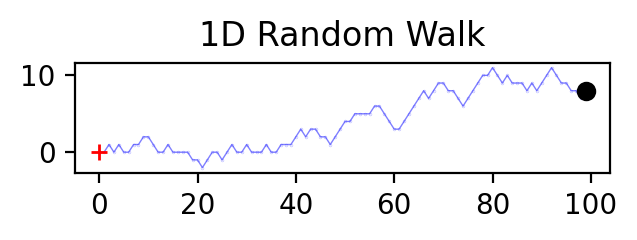

In [8]:
# 1D Random Walk

def generate_random_walk_1D(number_of_points, dims = 1, n_runs = 1, fig_path = None, step_set = [-1, 0, 1]):
    assert number_of_points>1
    # Define parameters for the walk
    step_n = number_of_points - 1 #number of points-1 because it doesn't count the origin
    origin = np.zeros((1,dims))
    # Simulate steps in 1D
    step_shape = (step_n,dims)
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)
    return path
    
def plot_1D_path(path):
    number_of_points = len(path)
    step_n = number_of_points - 1
    start = path[:1]
    stop = path[-1:]
    # Plot the path
    fig = plt.figure(figsize=(3,1),dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(np.arange(step_n+1), path, c="blue",alpha=0.25,s=0.05);
    ax.plot(path,c="blue",alpha=0.5,lw=0.5,ls="-",);
    ax.plot(0, start, c="red", marker="+")
    ax.plot(step_n, stop, c="black", marker="o")
    plt.title("1D Random Walk")
    plt.tight_layout(pad=0)
    return fig

random_walk_1D = generate_random_walk_1D(100)
random_walk_1D_fig = plot_1D_path(random_walk_1D)

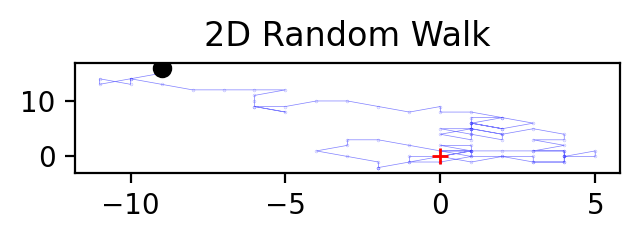

In [9]:
# 2D Random Walk

def generate_random_walk_2D(number_of_points, dims = 2, n_runs = 1, fig_path = None, step_set = [-1, 0 ,1]):
    """
    :param number_of_points: number of points in the random walk
    :param dims: number of dimensions of the points
    :param number_of_points: number of points in the random walk
    :param fig_path: path to save the figure to
    :return path: random walk np.array
    """
    assert (number_of_points>1) #is even because it is nuclei-golgi pair
    step_n = number_of_points - 1 #number of points-1 because it doesn't count the origin

    runs = np.arange(n_runs)
    step_shape = (step_n,dims)

    origin = np.zeros((1,dims))
    # Simulate steps in 2D
    
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)
    return path

def plot_2D_path(path):
    start = path[:1]
    stop = path[-1:]
    # Plot the path
    fig = plt.figure(figsize=(3,1),dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(path[:,0], path[:,1],c="blue",alpha=0.25,s=0.05);
    ax.plot(path[:,0], path[:,1],c="blue",alpha=0.5,lw=0.25,ls="-");
    ax.plot(start[:,0], start[:,1],c="red", marker="+")
    ax.plot(stop[:,0], stop[:,1],c="black", marker="o")
    plt.title("2D Random Walk")
    plt.tight_layout(pad=0)
    return fig

random_walk_2D = generate_random_walk_2D(100)
random_walk_2D_fig = plot_2D_path(random_walk_2D)

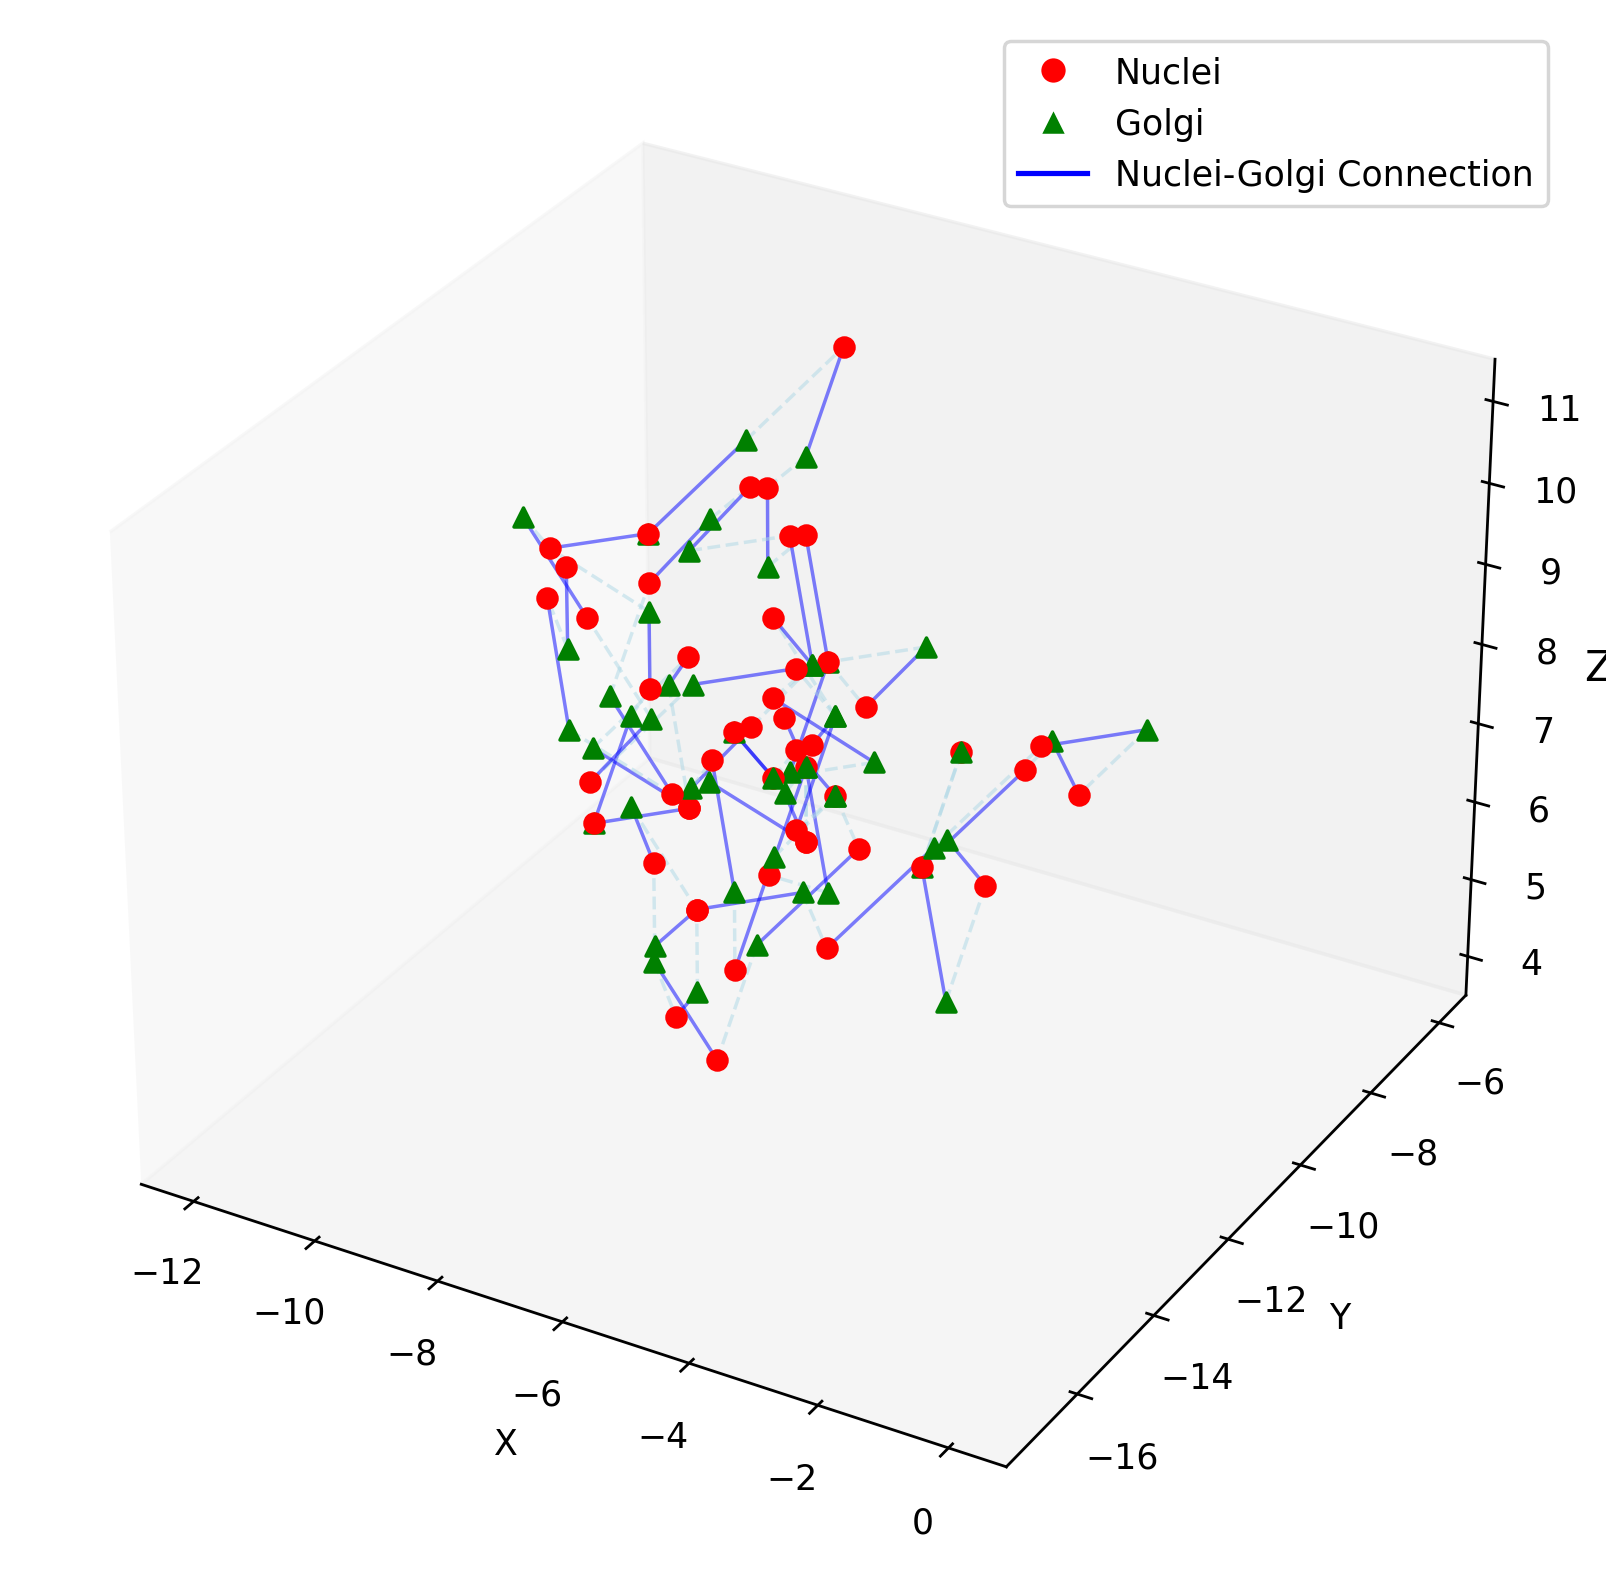

In [10]:
#3D Randonm Walk

def generate_random_walk_3D(number_of_points, dims = 3, n_runs = 1, fig_path = None):
    """
    :param number_of_points: number of points in the random walk
    :param dims: number of dimensions of the points
    :param number_of_points: number of points in the random walk
    :param fig_path: path to save the figure to
    :return path: random walk np.array
    """
    assert (number_of_points>1) #is even because it is nuclei-golgi pair
    step_n = number_of_points - 1 #number of points-1 because it doesn't count the origin

    step_set = [-1, 0 ,1]
    runs = np.arange(n_runs)
    step_shape = (step_n,dims)

    # Simulate steps in 3D
    origin = np.random.randint(low=-10,high=10,size=(1,dims))
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)
    
    return path

def plot_3D_path(path, nuclei_color="red", golgi_color="green"):
    # Create a figure and 3D axes
    fig = plt.figure(figsize=(8, 8), dpi=250)
    ax = fig.add_subplot(111, projection="3d")
    ax.grid(False)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z", labelpad=0, fontsize=12, x=0.95, y=0.9)

    
    # Plot nuclei and golgi points with lines
    for i in range(len(path) - 1):
        # Determine the linestyle based on even or odd index
        linestyle = "-"
        line_color = "blue"  # Default line color for non-dashed lines
        if i % 2 == 1:
            linestyle = "--"
            line_color = "lightblue"  # Light blue for dashed lines

        # Plot points
        marker = "o" if i % 2 == 0 else "^"  # Set markers for nuclei and golgi
        ax.scatter3D(path[i, 0], path[i, 1], path[i, 2], c=nuclei_color if i % 2 == 0 else golgi_color, marker=marker, s=30)
        ax.plot3D([path[i, 0], path[i + 1, 0]],
                  [path[i, 1], path[i + 1, 1]],
                  [path[i, 2], path[i + 1, 2]], linestyle, c=line_color, alpha=0.5, lw=1)  # Set line color

    # Plot the last point
    ax.scatter3D(path[-1, 0], path[-1, 1], path[-1, 2], c=golgi_color, marker="^", s=30)

    # Add a manual legend
    custom_legend = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=nuclei_color, markersize=8, label="Nuclei"),
        plt.Line2D([0], [0], marker="^", color="w", markerfacecolor=golgi_color, markersize=8, label="Golgi"),
        plt.Line2D([0], [0], linestyle="-", color="blue", label="Nuclei-Golgi Connection")
    ]
    ax.legend(handles=custom_legend, loc="upper right")

    return fig

random_walk_3D = generate_random_walk_3D(100)
random_walk_3D_fig = plot_3D_path(random_walk_3D)

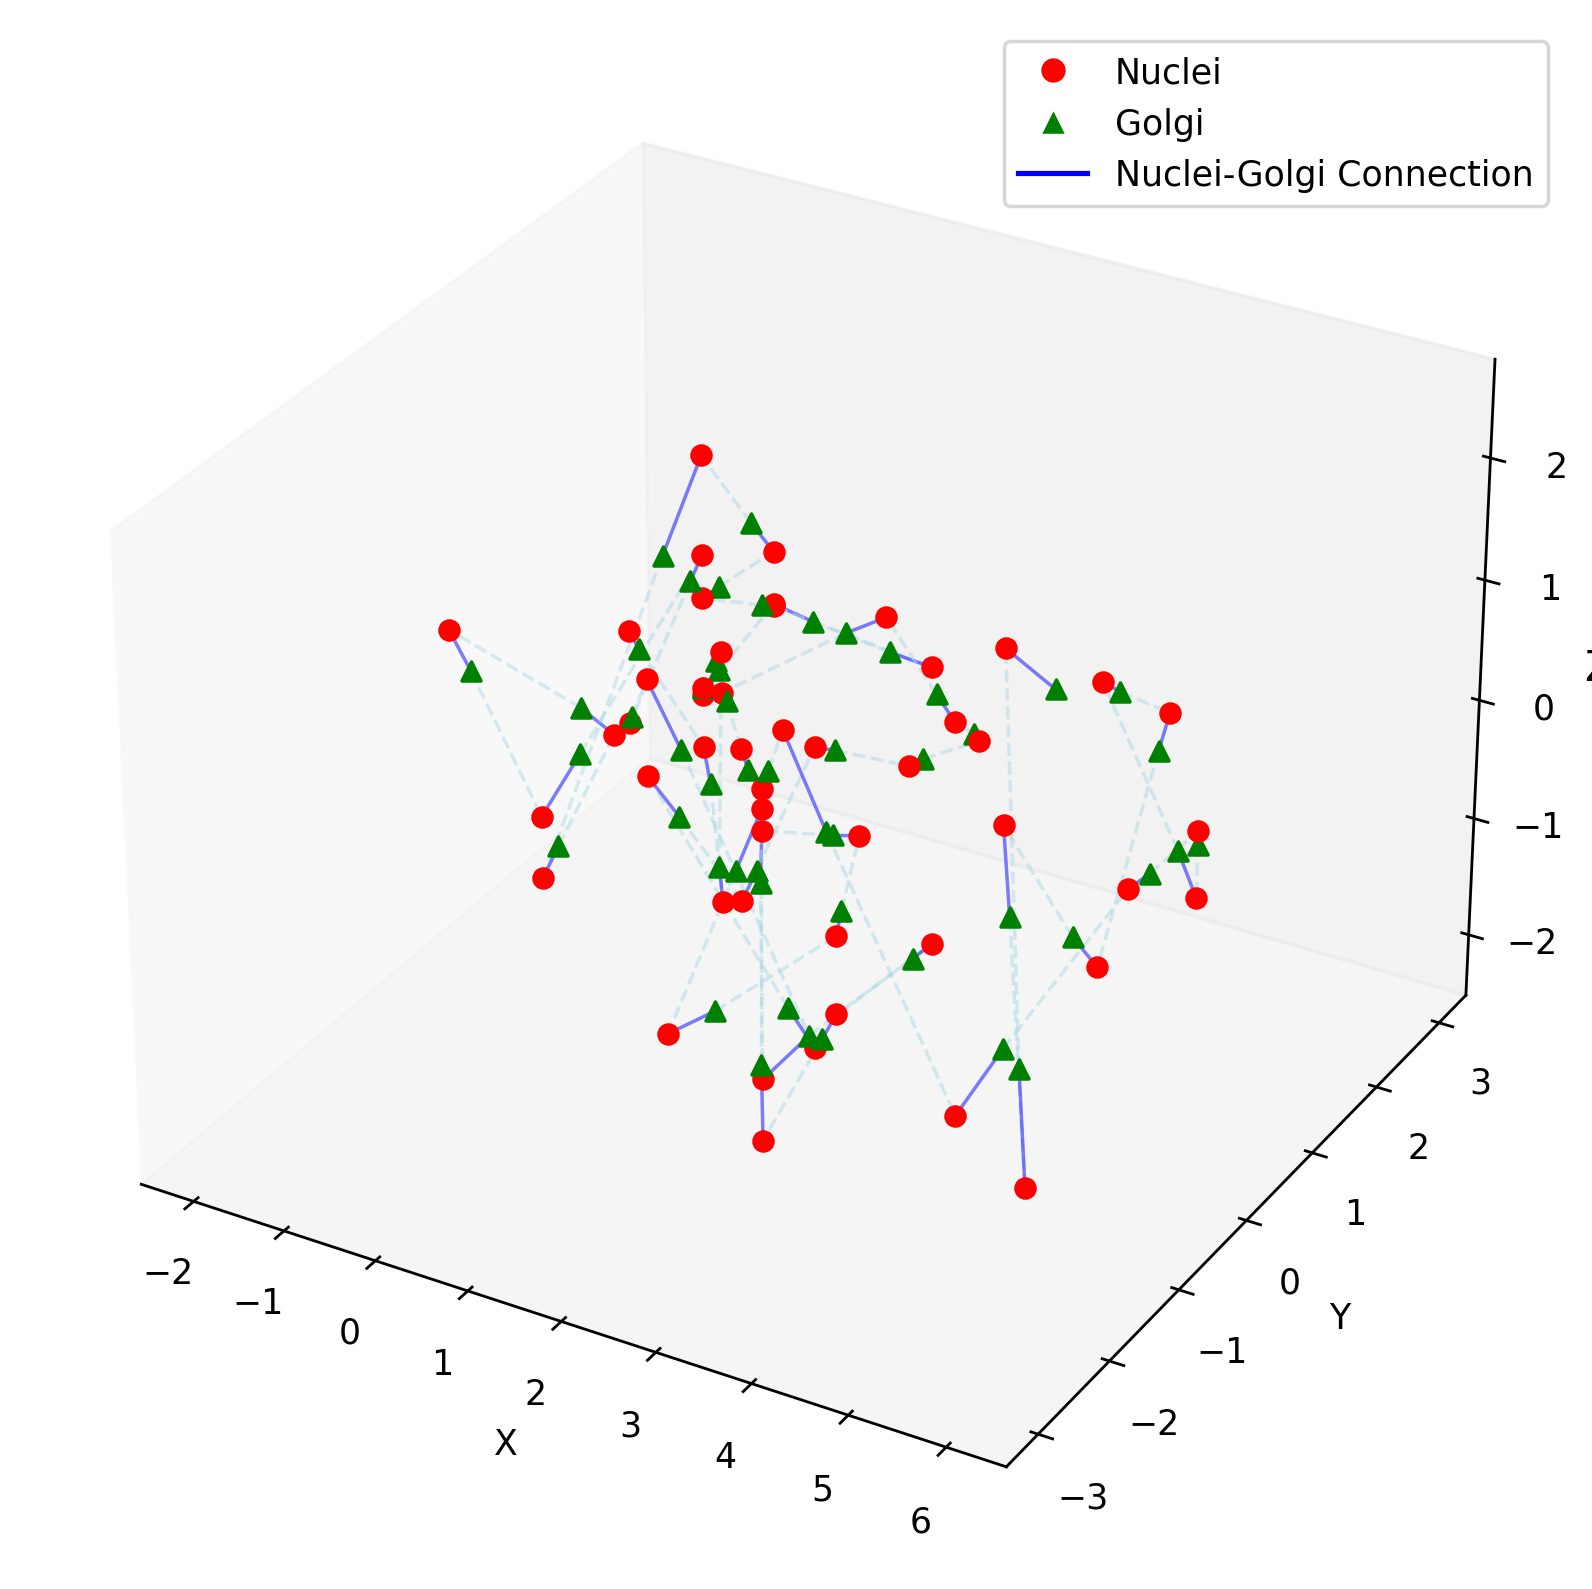

In [11]:
#Generate nuclei Golgi path

def calculate_golgi_coords(nuclei_i, nuclei_j, proximity_factor, deviation_factor):
    difference_vector = np.subtract(nuclei_j, nuclei_i)
    
    # Introduce a perturbation based on deviation_factor
    perturbation = np.random.uniform(-deviation_factor, deviation_factor, size=difference_vector.shape)
    
    return np.add(nuclei_i, (difference_vector + perturbation) * proximity_factor)

# Nuclei are a 3D random walk, Golgi are in the direction of the next nuclei and near it
def generate_nuclei_golgi_3D_path(number_of_points, proximity_factor_range=[0.15, 0.3], deviation_factor_range=[0.05, 0.2], generation_type="random_walk_2D_z_normal_distribution"):
    assert number_of_points % 2 == 0

    if generation_type == "random_walk_3D":
        nuclei_path_3D = generate_random_walk_3D(int(number_of_points / 2) + 1, dims=3, n_runs=1, fig_path=None)
    elif generation_type == "random_walk_2D_z_normal_distribution":
        nuclei_path_2D = generate_random_walk_2D(int(number_of_points / 2) + 1, dims=2, n_runs=1, fig_path=None)
        z_dimension_path = np.random.normal(0, 1, int(number_of_points / 2) + 1).reshape(int(number_of_points / 2) + 1, 1)
        nuclei_path_3D = np.hstack((nuclei_path_2D, z_dimension_path))
    elif generation_type == "random_walk_1D_y_fixed_z_normal_distribution":
        nuclei_path_1D = generate_random_walk_1D(int(number_of_points / 2) + 1, dims = 1, n_runs = 1, fig_path = None)
        y_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        z_dimension_path = np.random.normal(0, 1, int(number_of_points / 2) + 1).reshape(int(number_of_points / 2) + 1, 1)
        nuclei_path_3D = np.hstack((nuclei_path_1D, y_dimension_path, z_dimension_path))
    elif generation_type == "random_walk_1D_y_fixed_z_fixed":
        nuclei_path_1D_x = generate_random_walk_1D(int(number_of_points / 2) + 1, dims = 1, n_runs = 1, fig_path = None)
        y_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        z_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        nuclei_path_3D = np.hstack((nuclei_path_1D_x, y_dimension_path, z_dimension_path))
    elif generation_type=="lin_1D_y_random_walk_z_fixed":
        nuclei_path_1D_x = np.expand_dims(np.linspace(0, number_of_points, num = int(number_of_points / 2) + 1), axis = 1)
        y_dimension_path = generate_random_walk_1D(int(number_of_points / 2) + 1, dims = 1, n_runs = 1, fig_path = None)
        z_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        nuclei_path_3D = np.hstack((nuclei_path_1D_x, y_dimension_path, z_dimension_path))
    elif generation_type=="lin_1D_y_fixed_z_fixed":
        nuclei_path_1D_x = np.expand_dims(np.linspace(0, number_of_points, num = int(number_of_points / 2) + 1), axis = 1)
        y_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        z_dimension_path = np.zeros((int(number_of_points / 2) + 1, 1))
        nuclei_path_3D = np.hstack((nuclei_path_1D_x, y_dimension_path, z_dimension_path))
        
    # Create the final path
    path_3D = [0] * number_of_points

    # Fill the nuclei first
    for i in range(0, len(path_3D), 2):
        if (i % 2 == 0):
            path_3D[i] = nuclei_path_3D[int(i / 2)]

    # Fill the golgi
    for i in range(1, len(path_3D), 2):
        if (i % 2 != 0):
            nuclei_i_pos = int(i / 2)
            nuclei_j_pos = int(i / 2) + 1
            nuclei_i = nuclei_path_3D[nuclei_i_pos]
            nuclei_j = nuclei_path_3D[nuclei_j_pos]
            
            # Randomly choose proximity_factor and deviation_factor within specified ranges
            proximity_factor = np.random.uniform(proximity_factor_range[0], proximity_factor_range[1])
            deviation_factor = np.random.uniform(deviation_factor_range[0], deviation_factor_range[1])
            
            path_3D[i] = calculate_golgi_coords(nuclei_i, nuclei_j, proximity_factor, deviation_factor)

    path_3D = np.vstack(path_3D)

    return path_3D

nuclei_golgi_3D_path = generate_nuclei_golgi_3D_path(100, generation_type="random_walk_2D_z_normal_distribution")
nuclei_golgi_3D_path_fig = plot_3D_path(nuclei_golgi_3D_path)

In [17]:
def array_to_csv(array : np.array, csv_path : str, separator = ",", columns_order=['YN', 'XN', 'YG', 'XG', 'ZN', 'ZG']):
    with open(csv_path, 'w') as fp:
        for i in range(len(array)):
            row_array = array[i]
            array_dict = {}
            array_dict["XN"], array_dict["YN"], array_dict["ZN"], array_dict["XG"], array_dict["YG"], array_dict["ZG"] = row_array[0], row_array[1], row_array[2], row_array[3], row_array[4], row_array[5]
            new_array = [array_dict[col] for col in columns_order]
            row = separator.join(str(v) for v in new_array)
            if(i!=(len(array)-1)):#only write \n up to the line before the last line
                row+="\n"
            fp.write(row)
    return

def generate_artificial_dataset(output_dir, 
                                n_samples, number_points_dist = {"type":"constant", "count":150}, 
                                proximity_factor_range =[0.15, 0.3], deviation_factor_range=[0.05, 0.2],
                                generation_type="random_walk_2D_z_normal_distribution"):
    
    file_name_prefix = "Crop";
    
    for i in range(n_samples):
        
        if number_points_dist["type"]=="normal":
            #i.e. number_points_dist = {"type":"normal", "mu":150,"sigma":10, "min":80}, generate a number of points according to normal distribution
            number_of_points = round(np.random.normal(number_points_dist["mu"], number_points_dist["sigma"], 1)[0])
        elif(number_points_dist["type"]=="constant"):
            #i.e. number_points_dist = {"type":"constant", "count":150}, generate a constant number of points
            number_of_points = number_points_dist["count"]

        # Make sure number_of_points is even
        number_of_points = number_of_points + 1 if number_of_points % 2 != 0 else number_of_points
        
        new_data_array = generate_nuclei_golgi_3D_path(number_of_points, proximity_factor_range=proximity_factor_range, 
                                                  deviation_factor_range=deviation_factor_range, 
                                                  generation_type=generation_type)
        
        file_name = file_name_prefix+"_"+str(i)+".csv"
        new_data_array = new_data_array.reshape(int(new_data_array.shape[0]/2), int(new_data_array.shape[1]*2))
        array_to_csv(new_data_array, os.path.join(output_dir, file_name))
        
    return

In [38]:
output_dir = "../data/synthetic_1000_points/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
n_samples = 8
generate_artificial_dataset(output_dir, n_samples, number_points_dist = {"type":"constant", "count":1000})

### Generate Artificial Data

In [32]:
dfs_to_normalize = [
    "../data/synthetic_algo_100_points",
    "../data/synthetic_algo_200_points",
    "../data/synthetic_algo_300_points",
    "../data/synthetic_algo_400_points",
    "../data/synthetic_algo_500_points",
    "../data/synthetic_algo_600_points",
    "../data/synthetic_algo_700_points",
    "../data/synthetic_algo_800_points",
    "../data/synthetic_algo_900_points",
    "../data/synthetic_algo_1000_points"
    ]

In [33]:
def minmax_normalize(df, max_values):
    return (df-0) / max_values

for folder_path in dfs_to_normalize:
    csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

    # List CSV files in the folder
    dfs = [pd.read_csv(f, delimiter=",", header=None) for f in csv_files]

    df_concat = pd.concat(dfs).reset_index(drop=True)
    max_values = df_concat.abs().max()
    
    output_folder = folder_path+"_normalized"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through CSV files again to apply min-max normalization and save
    for csv_file in csv_files:
        # Read CSV file
        df = pd.read_csv(csv_file, delimiter=",", header=None)
        
        # Apply min-max normalization
        df_normalized = minmax_normalize(df, max_values)
        
        # Write normalized DataFrame to a new CSV file
        output_file = os.path.join(folder_path+"_normalized", os.path.basename(csv_file))
        df_normalized.to_csv(output_file, index=False, header = False)